In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import copy
import collections 
import scipy.stats as stats
import netgraph
import powerlaw as pwl
import seaborn as sns

with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']

MEDIUM_SIZE = 18
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']

def summarize_reasons(filename, n_samples=20, n_categories=5, n_resamples=5, degrees=False, categories=None):
    random.seed(1)
    np.random.seed(1)

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    reason_list = collections.defaultdict(list)

    all_reasons = []

    for d in data:        
        for result in d["reasons"]:
            if result and 'reason' in result.keys():
                reason_list[d['temperature']].append(result['reason'])
                all_reasons.append(result['reason'])

    if categories is None:
        categorization_prompt = f"""
        # Task

        You are given a list of reasons and your task to find {n_categories} categories that best describe the reasons.

        # Input

        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(random.sample(all_reasons, len(reason_list) * n_samples))}
        </REASONS>

        # Output

        The output should be given in JSON format with the following structure:

        [
            {{
                "category" : category,
                "description" : short description of the category
            }}, ...
        ]

        # Notes
        * The names of the categories must be descriptive and mutually exclusive.

        ```json
        """

        for _ in range(10):
            try:
                ans = get_response(categorization_prompt, temperature=0, system_prompt="You are a helpful assistant")
                categories = json.loads(ans.split('```')[0])
                print(categories)
                break

            except Exception as e:
                print(e)
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    category_list = [c['category'] for c in categories]

    records = []

    for i, (k, v) in enumerate(reason_list.items()):
        print('Temperature', k)
        if len(v) <= n_samples:
            n_resamples = 1

        for r in range(n_resamples):
            prompt = f"""
            # Task
            You are given a list of reasons and your task is to classify them into categories.

            # Input
            The input is a list of reasons. The list is given below after chevrons:
            <REASONS>
            {json.dumps(random.sample(v, n_samples), indent=4)}
            </REASONS>

            ## Categories
            The names of the categories are given below after chevrons:
            <CATEGORIES>
            {json.dumps(categories, indent=4)}
            </CATEGORIES>

            Each reason must be assigned to exactly one of the categories.
            
            # Output
            The output should be given as a list of JSON objects with the following structure:

            [
                {{
                        "reason" : reason,
                        "category" : category name
                }}, ...
            ]

            ```json
            """

            for _ in range(10):
                try:
                    ans = get_response(prompt, temperature=0, system_prompt="You are a helpful assistant")

                    result = json.loads(ans.split('```')[0])

                    assert(isinstance(result, list))

                    reason_types = collections.defaultdict(float)

                    total = 0

                    for reason in result:
                        if reason['category'] in category_list:
                            reason_types[reason['category']] += 1
                            total += 1

                    # for key, val in reason_types.items():
                    #     reason_types[key] = val / total * 100

                   
                    break
                except Exception as e:
                    print(e)

            for key, val in reason_types.items():
                records.append({
                    'Temperature' : k,
                    'Category' : key,
                    'Frequency' : val,
                    'Resample' : r
                })


    df = pd.DataFrame.from_records(records)

    fig.suptitle('Reasoning for Principle 1', fontsize=MEDIUM_SIZE)

    sns.barplot(data=df, x='Category', y='Frequency', hue='Temperature', ax=ax, palette='Set2')

    plt.legend(fontsize=0.75*SMALL_SIZE, title='Temperature')

    plt.xticks(rotation=0, fontsize=SMALL_SIZE)

    fig.tight_layout()

    fig.savefig(f'figures/principle_1/principle_1_reasons{"_neighbors" if not degrees else ""}.png', dpi=300, bbox_inches='tight')
               
def draw_graph(G, ax, G0=None, use_netgraph=True, nodecolor='#d35400'):
    if not G0:
        G0_edges = set()
    else:
        G0_edges = set(G0.edges())
    G_edges = set(G.edges()) - G0_edges
    if not use_netgraph:
        pos = nx.spring_layout(G)

        if not G0:
            nx.draw(G, pos, ax=ax, node_size=10, width=1.5, node_color='#d35400', alpha=0.7, edge_color='#34495e')
        else:


            nx.draw_networkx_edges(G, pos, edgelist=G0_edges, width=1.5, alpha=0.5, edge_color='#34495e', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_edges, width=1.5, alpha=1, edge_color='#e67e22', ax=ax)

            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=10, node_color=nodecolor, alpha=0.7, ax=ax)
    else:
        edge_color = {(u, v) : '#34495e' if (u, v) in G0_edges else '#e67e22'  for (u, v) in G.edges()}

        netgraph.Graph(G, node_layout='spring', node_color=nodecolor, node_size=1.0, edge_color=edge_color, ax=ax)

    ax.set_axis_off()

def create_preferrential_attachment(T, n0, temperature, degrees=True, method='llm'):
    G = nx.empty_graph(n0)

    # G = nx.erdos_renyi_graph(n0, 0.5)

    Gs = []
    results = []

    for t in range(n0, n0 + T):
        print(f'Adding node {t}')
        if t > 0:
            if method == 'llm':
                result = select_neighbor(G, t, temperature, degrees=degrees)
            elif method == 'ba':
                result = {'name' : random.choice(list(G.nodes(), weights=[G.degree(n) for n in G.nodes()]))}

        G.add_node(t)
        
        if t > 0 and result:
            v = result['name']
            G.add_edge(t, v)

        Gs.append(G.copy())
        results.append(result)

    return Gs, results

def select_neighbor(G, t, temperature, degrees=True):
    candidates = []
    for v in G.nodes():
        if v != t:
            if degrees:
                candidates.append({'name' : v, 'number_of_friends' : G.degree(v)})
            else:
                candidates.append({'name' : v, 'friends' : list(G.neighbors(v))})

    # if len(candidates) > 200:
    #     candidates = random.sample(candidates, 200)

    preferential_attachment_prompt = f"""
    # Task
    Your task is to select a person to be friends with.

    # Input
    The input is a list of dictionaries. 
    
    The profiles are given below after chevrons:
    
    <PROFILES>
    {json.dumps(candidates)}
    </PROFILES>

    # Output
    The output should be given in JSON format with the following structure

    {{
        "name" : name of the person you selected,
        "reason" : reason for selecting the person
    }}

    # Notes

    - The name of the person you selected must be one of the names in the input.
    
    ```json
    """

    for i in range(10):
        try:
            result = json.loads(get_response(preferential_attachment_prompt, temperature=temperature).split('```')[0])
            if result['name'] in G.nodes():
                print('NEW EDGE', result)
                return result
        except Exception as e:
            print(e)
        
def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, degrees=True):

    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')

    print(saved_scenarios)

    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')
                    n0 = 1
                    Gs, reasons = create_preferrential_attachment(n, n0, temperature=temperature, degrees=degrees)

                    temp = {
                        'n' : n,
                        'n0' : n0,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

    f.close()

def analyze_experiments(filename, dgr=True):

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']


    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    degree_freqs = collections.defaultdict(list)
    dergee_freqs_barabasi_albert = collections.defaultdict(list)

    wasserstein_distances = collections.defaultdict(list)
    ks_statistics = collections.defaultdict(list)
    gammas = collections.defaultdict(list)
    gammas_barabasi_albert = collections.defaultdict(list)
    sigmas = collections.defaultdict(list)
    sigmas_barabasi_albert = collections.defaultdict(list)
    ks_powerlaw = collections.defaultdict(list)
    confidence_ks_intervals = collections.defaultdict(list)
    pwl_fits = collections.defaultdict(list)
    pwl_fits_barabasi_albert = collections.defaultdict(list)

    final_graphs = collections.defaultdict(list)

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            G.remove_nodes_from(list(nx.isolates(G)))
            Gs.append(G)

        final_graphs[d['n'], d['temperature']].append((Gs[-1].copy(), Gs[0].copy()))

        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        fig_barabasi_albert, ax_barabasi_albert = plt.subplots(1, 2, figsize=(10, 5))
    
        # fig.suptitle(f'Graph created based on Principle 1 with $n = {d["n"]}$, $n_0 = {d["n0"]}$, temperature = {d["temperature"]}')

        G_barabasi_albert = nx.barabasi_albert_graph(n=d['n'], m=1, seed=1)

        for i, t in enumerate([len(Gs) // 3, 2 * len(Gs) // 3, len(Gs) - 1]):
            G = Gs[t]
            ax[i].set_title(f'$t = {t}$')
            if len(Gs[0]) > 2:
                draw_graph(G, ax=ax[i], G0=Gs[0])
            else:
                draw_graph(G, ax=ax[i])
            
        draw_graph(G_barabasi_albert, ax=ax_barabasi_albert[0], nodecolor='#3498db')


        degrees = [G.degree(n) for n in G.nodes()]
        degrees_barabasi_albert = [G_barabasi_albert.degree(n) for n in G_barabasi_albert.nodes()]

        powerlaw_fit = pwl.Fit(degrees, discrete=True)

        print(f'Temperature {d["temperature"]}: xmin: {powerlaw_fit.xmin}, alpha: {powerlaw_fit.alpha}, sigma: {powerlaw_fit.sigma}')

        powerlaw_fit_barabasi_albert = pwl.Fit(degrees_barabasi_albert, discrete=True)

        wasserstein_distances[d['n'], d['temperature']].append(stats.wasserstein_distance(degrees, degrees_barabasi_albert))
        gammas[d['n'], d['temperature']].append(powerlaw_fit.alpha)
        sigmas[d['n'], d['temperature']].append(powerlaw_fit.sigma)

        gammas_barabasi_albert[d['n'], d['temperature']].append(powerlaw_fit_barabasi_albert.alpha)
        sigmas_barabasi_albert[d['n'], d['temperature']].append(powerlaw_fit_barabasi_albert.sigma)

        ks_powerlaw[d['n'], d['temperature']].append(powerlaw_fit.power_law.KS(degrees))

        ax[-1].set_title('Degree distribution')
        ax_barabasi_albert[-1].set_title('Degree distribution')

        powerlaw_fit.plot_ccdf(linewidth=3, ax=ax[-1], color='#e74c3c', label='LLM (Empirical)')
        powerlaw_fit_barabasi_albert.plot_ccdf(linewidth=3, ax=ax[-1], color='#3498db', label='BA (Empirical)')

        powerlaw_fit_barabasi_albert.plot_ccdf(linewidth=3, ax=ax_barabasi_albert[-1], color='#3498db', label='BA (Empirical)')

        powerlaw_fit.power_law.plot_ccdf(ax=ax[-1], color='#e74c3c', linestyle='--', label='LLM (Power law fit)')
        powerlaw_fit_barabasi_albert.power_law.plot_ccdf(ax=ax[-1], color='#3498db', linestyle='--', label='BA (Power law fit)')

        powerlaw_fit_barabasi_albert.power_law.plot_ccdf(ax=ax_barabasi_albert[-1], color='#3498db', linestyle='--', label='BA (Power law fit)')

        print(f'BA powerlaw fit gamma: {powerlaw_fit_barabasi_albert.power_law.alpha:.2f} +- {powerlaw_fit_barabasi_albert.power_law.sigma:.2f}')

        pwl_fits[d['n'], d['temperature']].append(powerlaw_fit)
        pwl_fits_barabasi_albert[d['n'], d['temperature']].append(powerlaw_fit_barabasi_albert)

        print(f'Temperature: {d["temperature"]}, KS Test with BA (empirical): {stats.ks_2samp(degrees, degrees_barabasi_albert)}')
        print()
      
        # Exports to perform bootstrap hypothesis test in R using the poweRlaw package
        df = pd.DataFrame(degrees)
        df.to_csv(f'degrees{"_neighbors" if not dgr else ""}_{d["n"]}_{d["simulation"]}_{d["temperature"]}.txt', header=None, index=False)

        ax[-1].legend()
        ax[-1].set_xlabel('Degree')
        ax[-1].set_ylabel('CCDF')

        ax_barabasi_albert[-1].legend()
        ax_barabasi_albert[-1].set_xlabel('Degree')
        ax_barabasi_albert[-1].set_ylabel('CCDF')

        fig.tight_layout()

        fig.suptitle(f'Temperature = {d["temperature"]}', y=1.05)
        fig_barabasi_albert.suptitle('BA Model', y=1.05)


        fig.savefig(f'figures/principle_1/principle_1_{d["n"]}_{d["simulation"]}_{d["temperature"]}{"_neighbors" if not dgr else ""}.png', dpi=300, bbox_inches='tight')
        fig_barabasi_albert.savefig(f'figures/principle_1/principle_1_{d["n"]}_{d["simulation"]}_{d["temperature"]}_barabasi_albert{"_neighbors" if not dgr else ""}.png', dpi=300, bbox_inches='tight')

    # fig, ax = plt.subplots(1, len(degree_freqs), figsize=(5 * len(degree_freqs), 5))

    # for i, k in enumerate(sorted(degree_freqs)):

    #     degree_freq = np.mean(degree_freqs[k], axis=0)
    #     degree_freq_barabasi_albert = np.mean(dergee_freqs_barabasi_albert[k], axis=0)

    #     ax[i].set_title(f'$n = {k[0]}$, temperature={k[1]}')
    #     ax[i].loglog(degree_freq, color='#16a085', marker='x', label='LLM')
    #     ax[i].loglog(degree_freq_barabasi_albert, color='#2980b9', marker='x', label='BA') 
    #     ax[i].set_xlabel('Degree')
    #     ax[i].set_ylabel('Frequency')

    # fig.tight_layout()
    # fig.savefig(f'figures/principle_1/principle_1_overall.png')

    fig, ax = plt.subplots(1, 1 + len(final_graphs), figsize=(5 * (1 + len(final_graphs)), 5), squeeze=False, gridspec_kw={'width_ratios': [1] * (1 + len(final_graphs))})
    # fig.suptitle(f'Graphs created based on Principle 1 with $n = {d["n"]}$, $n_0={d["n0"]}$')

    for i, k in enumerate(sorted(final_graphs.keys())):
        G, G0 = final_graphs[k][0]
        
        if len(G0) > 2:
            draw_graph(G, ax[0, i], G0=G0, nodecolor=palette[i])
        else:
            draw_graph(G, ax[0, i], nodecolor=palette[i])
        ax[0, i].set_title(f'Temperature = {k[-1]}, $\hat \gamma$ = {gammas[k][0]:.2f} $\pm$ {sigmas[k][0]:.2f}')


    for i, k in enumerate(sorted(pwl_fits.keys())):
        powerlaw_fit = pwl_fits[k][0]
        powerlaw_fit.plot_ccdf(linewidth=3, ax=ax[0, -1], color=palette[i], label=str(k[-1]))
        powerlaw_fit.power_law.plot_ccdf(ax=ax[0, -1], color=palette[i], linestyle='--')
    

    for i, k in enumerate(sorted(pwl_fits.keys())):

        powerlaw_fit_barabasi_albert = pwl_fits_barabasi_albert[k][0]

        if i == 0:
            powerlaw_fit_barabasi_albert.plot_ccdf(linewidth=3, ax=ax[0, -1], color='#7f8c8d', label='BA')
            powerlaw_fit_barabasi_albert.power_law.plot_ccdf(ax=ax[0, -1], color='#7f8c8d', linestyle='--')


    ax[0, -1].legend()
    ax[0, -1].set_xlabel('Degree')
    ax[0, -1].set_ylabel('Complemetary CDF')

    # for i, k in enumerate(sorted(gammas.keys())):
        
    #     if i == 0:
    #         ax[0, -2].scatter(k[-1] - 0.05, gammas[k][0], color='#e74c3c', alpha=0.7, s=50, marker='o', label='LLM')
    #     else:
    #         ax[0, -2].scatter(k[-1] - 0.05, gammas[k][0], color='#e74c3c', alpha=0.7, s=50, marker='o')
    #     ax[0, -2].errorbar(k[-1] - 0.05, gammas[k][0], yerr=sigmas[k][0], color='#e74c3c', alpha=0.7, capsize=5, linewidth=2)

    # for i, k in enumerate(sorted(gammas_barabasi_albert.keys())):
       
    #     if i == 0:
    #         ax[0, -2].scatter(k[-1] + 0.05, gammas_barabasi_albert[k][0], color='#3498db', alpha=0.7, s=50, marker='o', label='BA')
    #     else:
    #         ax[0, -2].scatter(k[-1] + 0.05, gammas_barabasi_albert[k][0], color='#3498db', alpha=0.7, s=50, marker='o')
    #     ax[0, -2].errorbar(k[-1] + 0.05, gammas_barabasi_albert[k][0], yerr=sigmas_barabasi_albert[k][0], color='#3498db', alpha=0.7, capsize=5, linewidth=2)

    # ax[0, -2].set_xlabel('Temperature')
    # ax[0, -2].set_ylabel('$\\gamma$')

    # ax[0, -2].legend(loc='upper right')

    # for i, k in enumerate(sorted(confidence_ks_intervals.keys())):
    #     ax[0, -1].scatter(k[-1], ks_powerlaw[k][0], color='#e74c3c', alpha=0.7, s=50, marker='o')

    # ax[0, -1].set_xlabel('Temperature')
    # ax[0, -1].set_ylabel('K-S Statistic vs. Power Law')


    fig.tight_layout()

    fig.savefig(f'figures/principle_1/principle_1_final_graphs{"_neighbors" if not dgr else ""}.png', dpi=300)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Calculating best minimal value for power law fit
Temperature 0.5: xmin: 2.0, alpha: 1.5042975450511276, sigma: 0.22552871832411678
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 0.5, KS Test with BA (empirical): KstestResult(statistic=0.30512437810945275, pvalue=9.927927540492516e-09, statistic_location=1, statistic_sign=1)

Calculating best minimal value for power law fit
Temperature 1.0: xmin: 3.0, alpha: 1.9203122854025065, sigma: 0.23762361031159965
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 1.0, KS Test with BA (empirical): KstestResult(statistic=0.14094527363184078, pvalue=0.034260667947169816, statistic_location=1, statistic_sign=1)

Calculating best minimal value for power law fit
Temperature 1.5: xmin: 4.0, alpha: 3.032934664002284, sigma: 0.3986912892925707
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 1.5, KS Test with 

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_node_layout.py:1024: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]


Calculating best minimal value for power law fit
Temperature 0.5: xmin: 1.0, alpha: 2.3896344573366974, sigma: 0.09826199481532667
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 0.5, KS Test with BA (empirical): KstestResult(statistic=0.325, pvalue=9.594235055800515e-10, statistic_location=1, statistic_sign=1)

Calculating best minimal value for power law fit
Temperature 1.0: xmin: 2.0, alpha: 1.487689833730209, sigma: 0.24384491686510446
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 1.0, KS Test with BA (empirical): KstestResult(statistic=0.31, pvalue=6.865581733487208e-09, statistic_location=1, statistic_sign=1)

Calculating best minimal value for power law fit
Temperature 1.5: xmin: 2.0, alpha: 2.4695175370747435, sigma: 0.27288255600420286
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 1.5, KS Test with BA (empirical): KstestResul

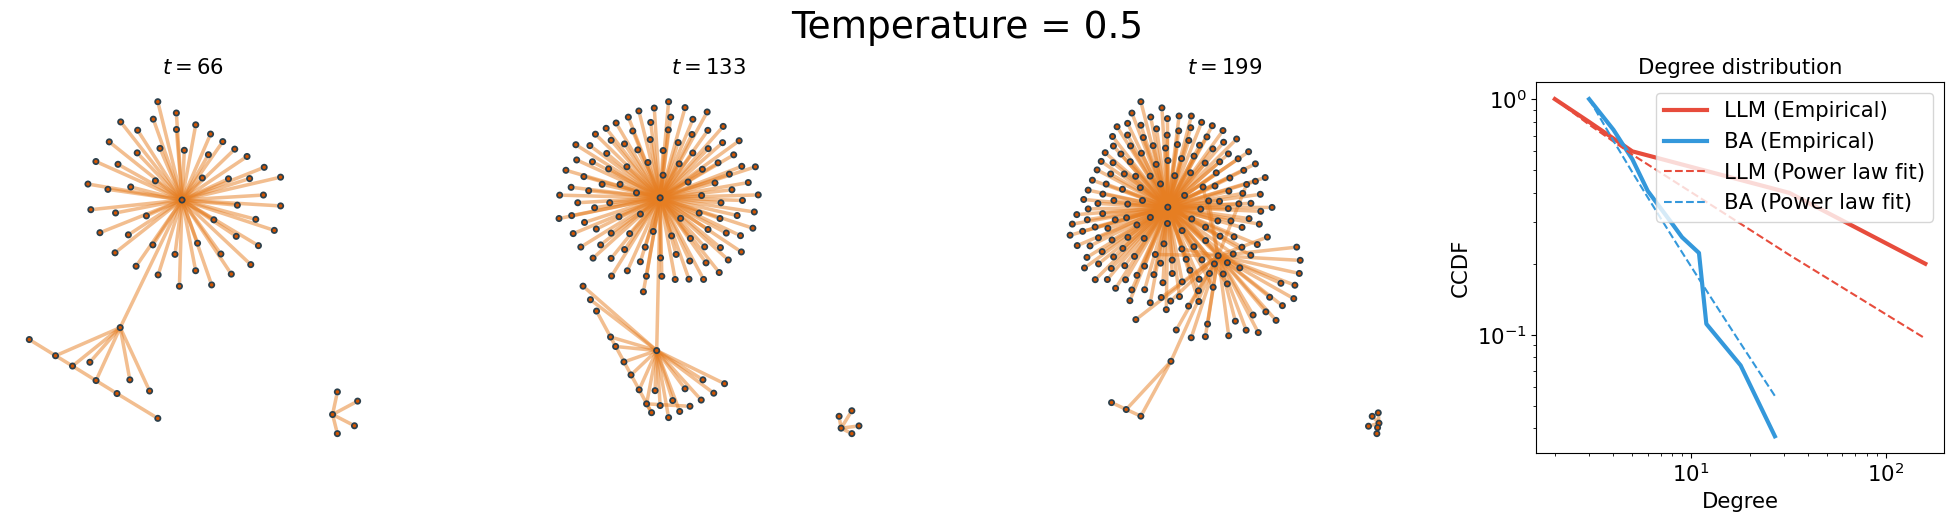

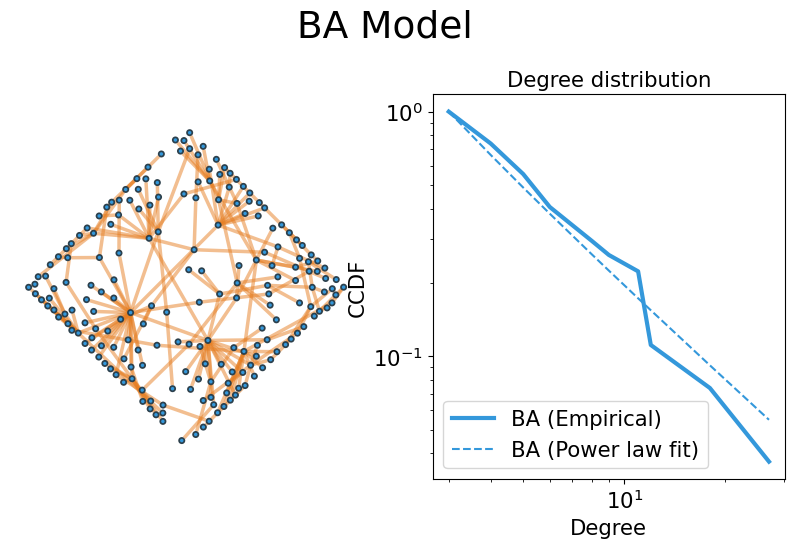

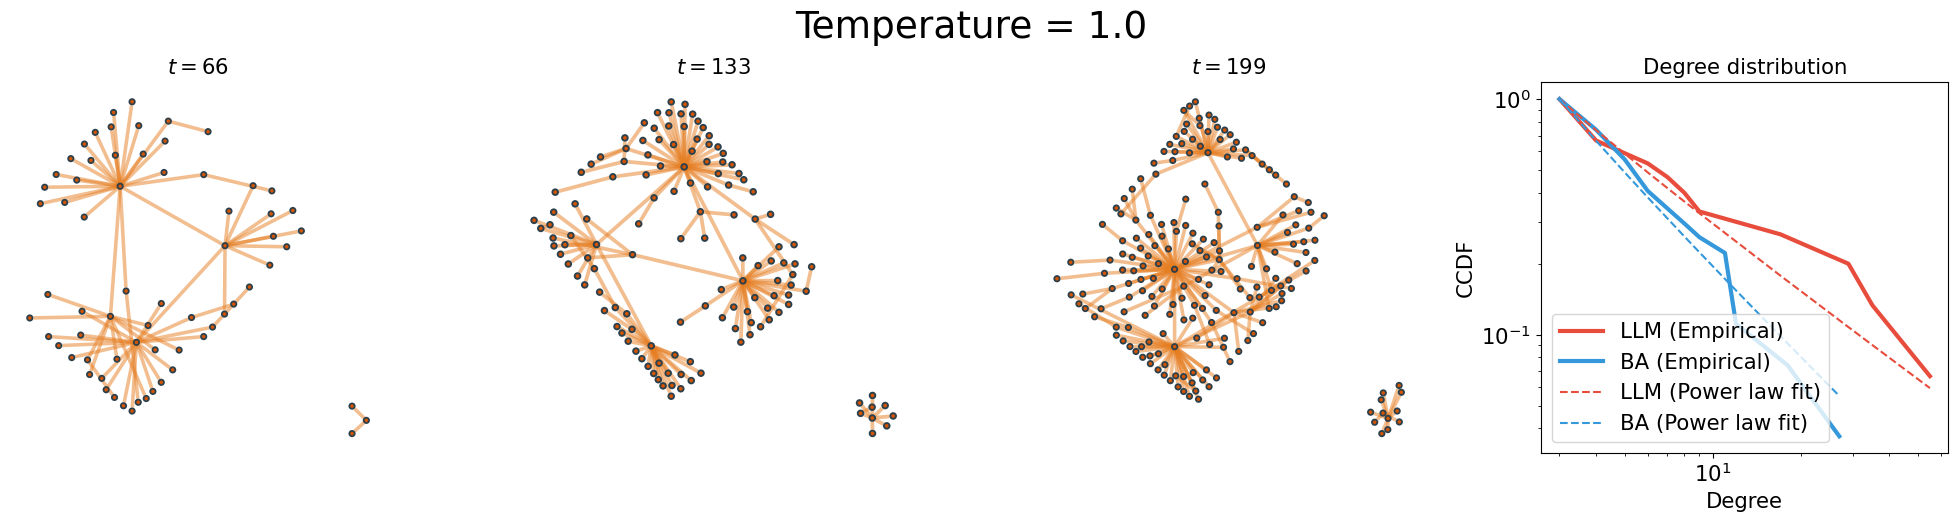

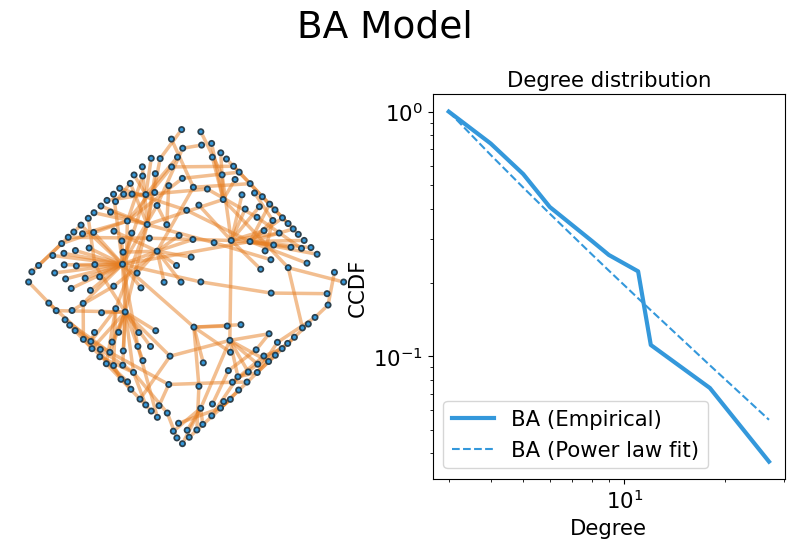

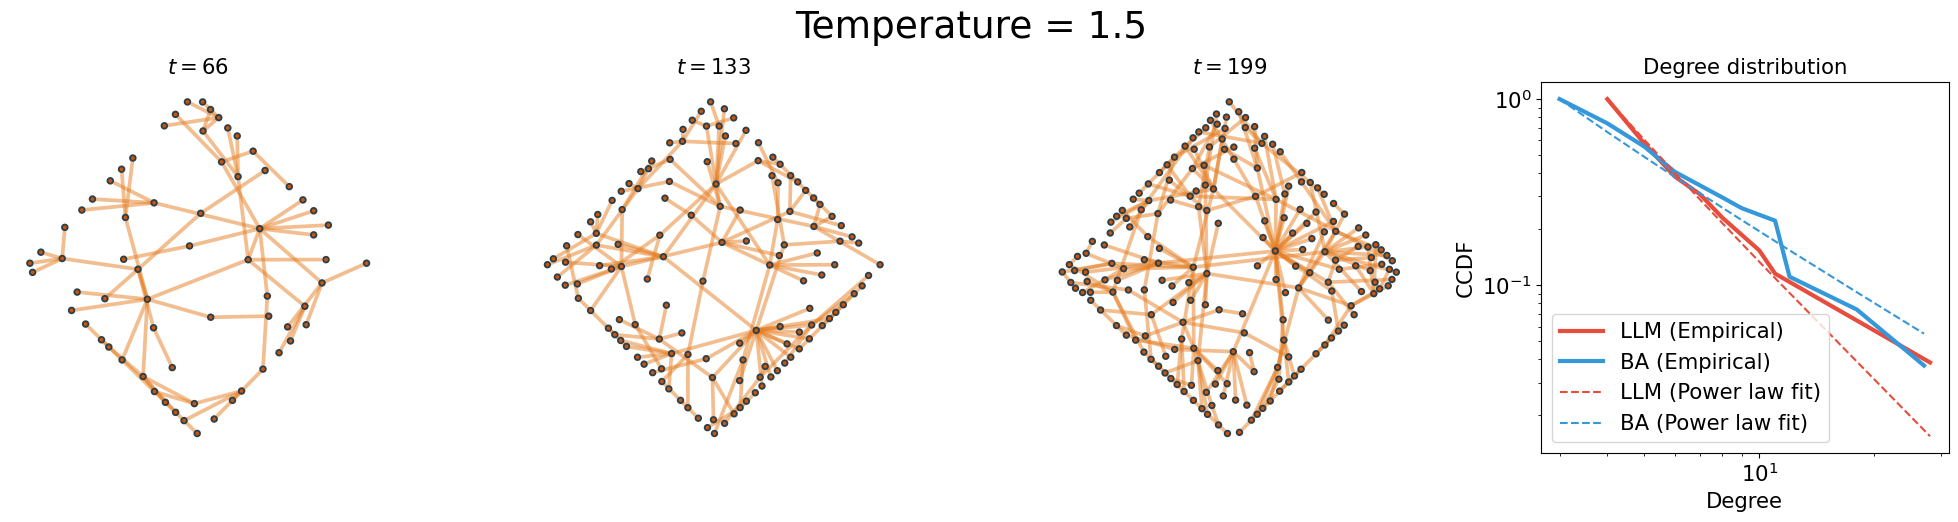

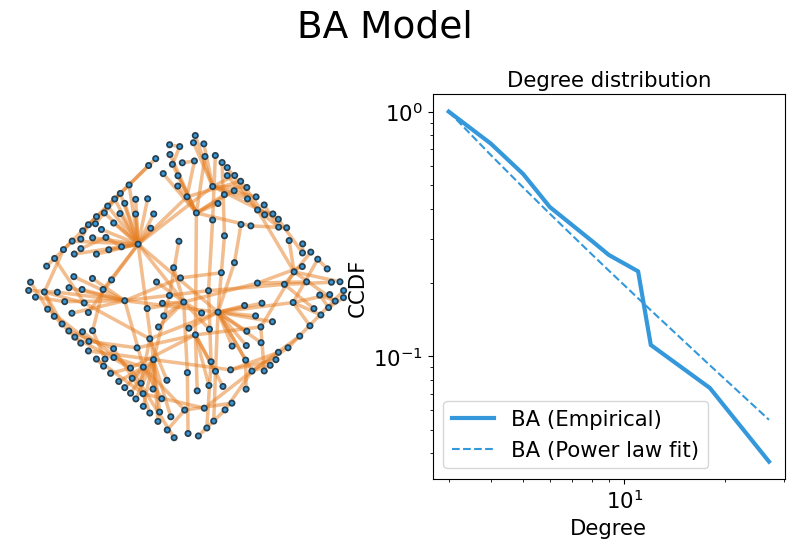

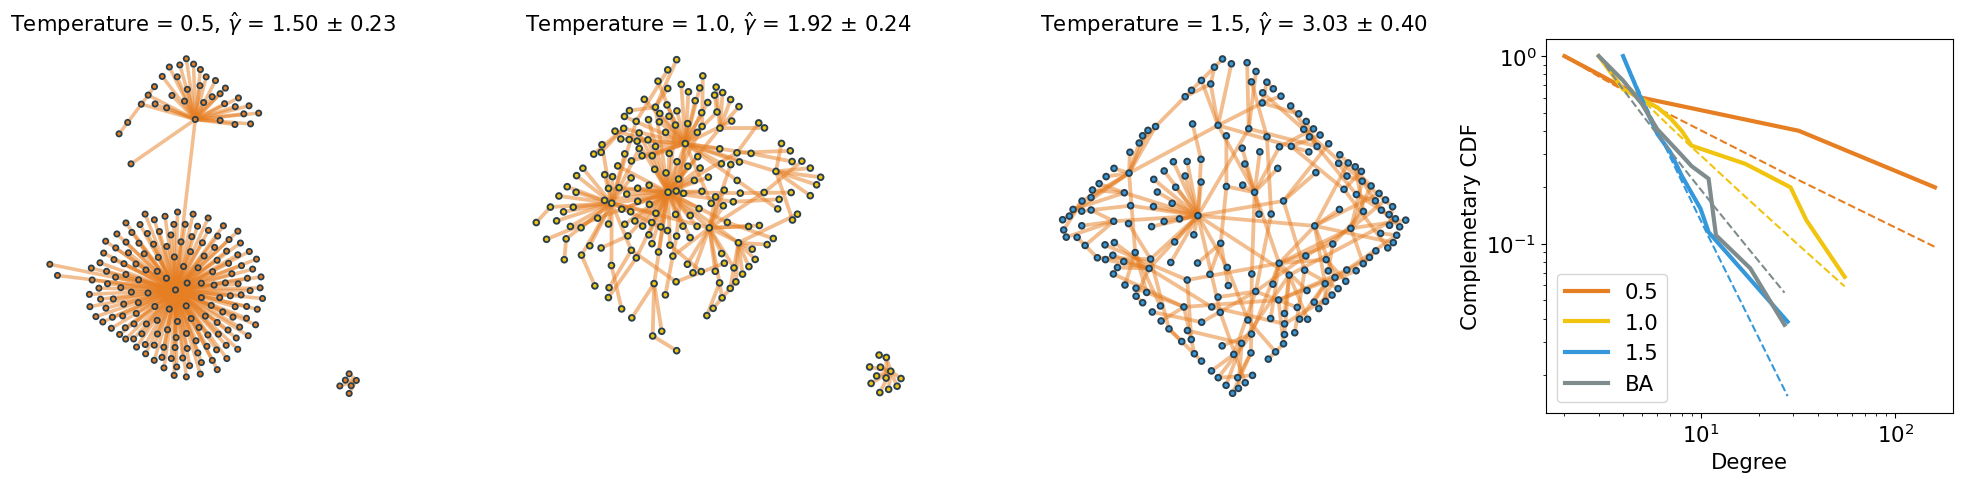

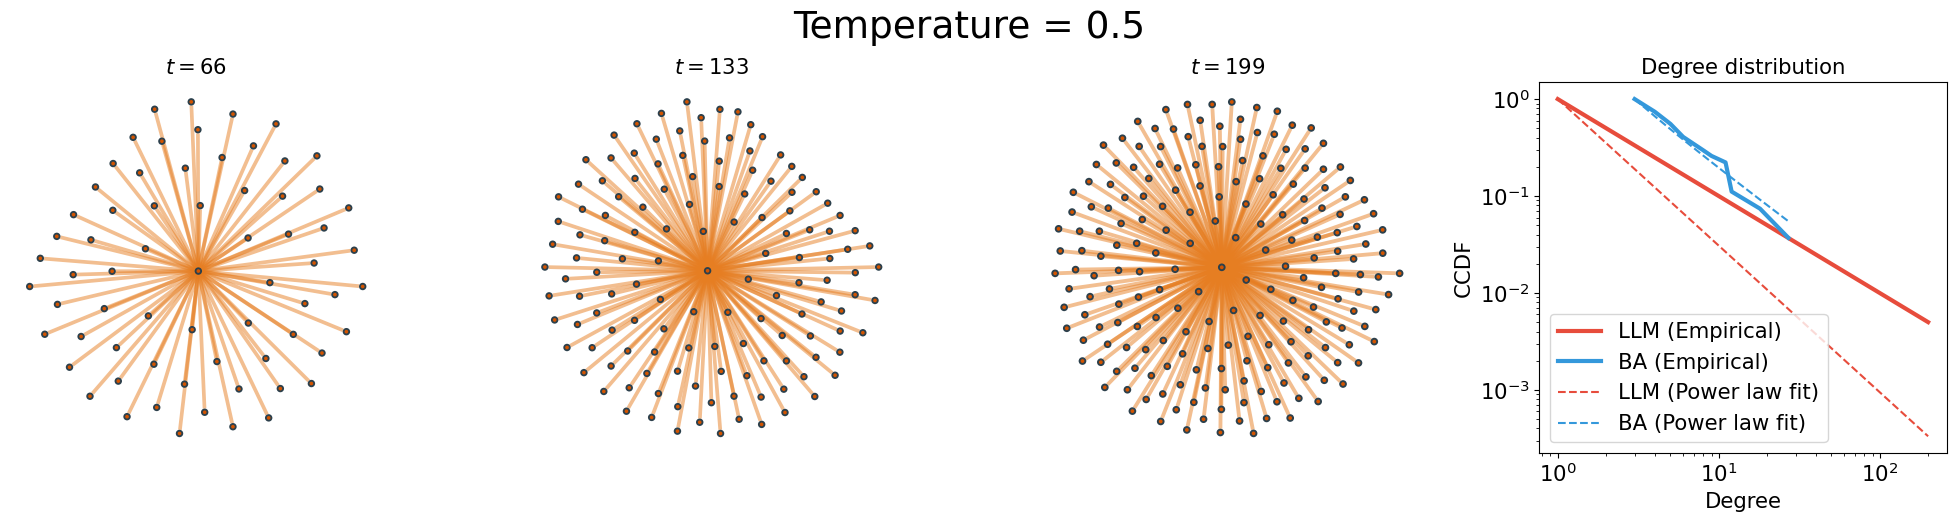

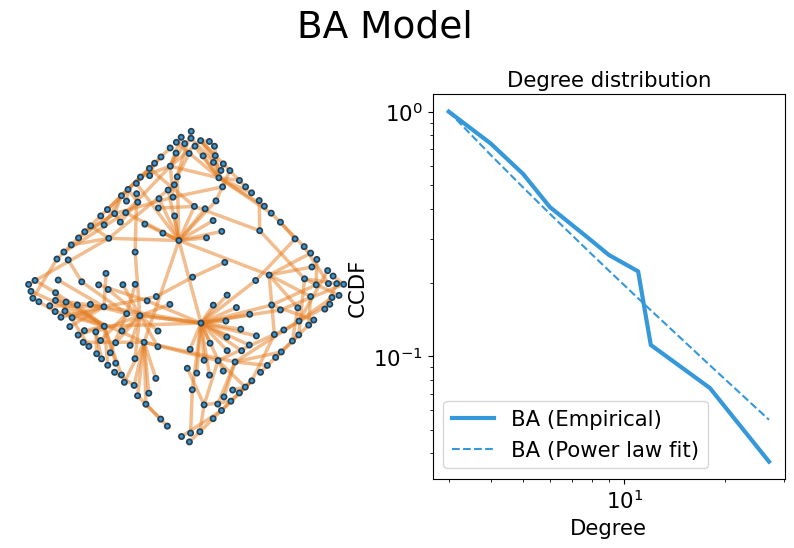

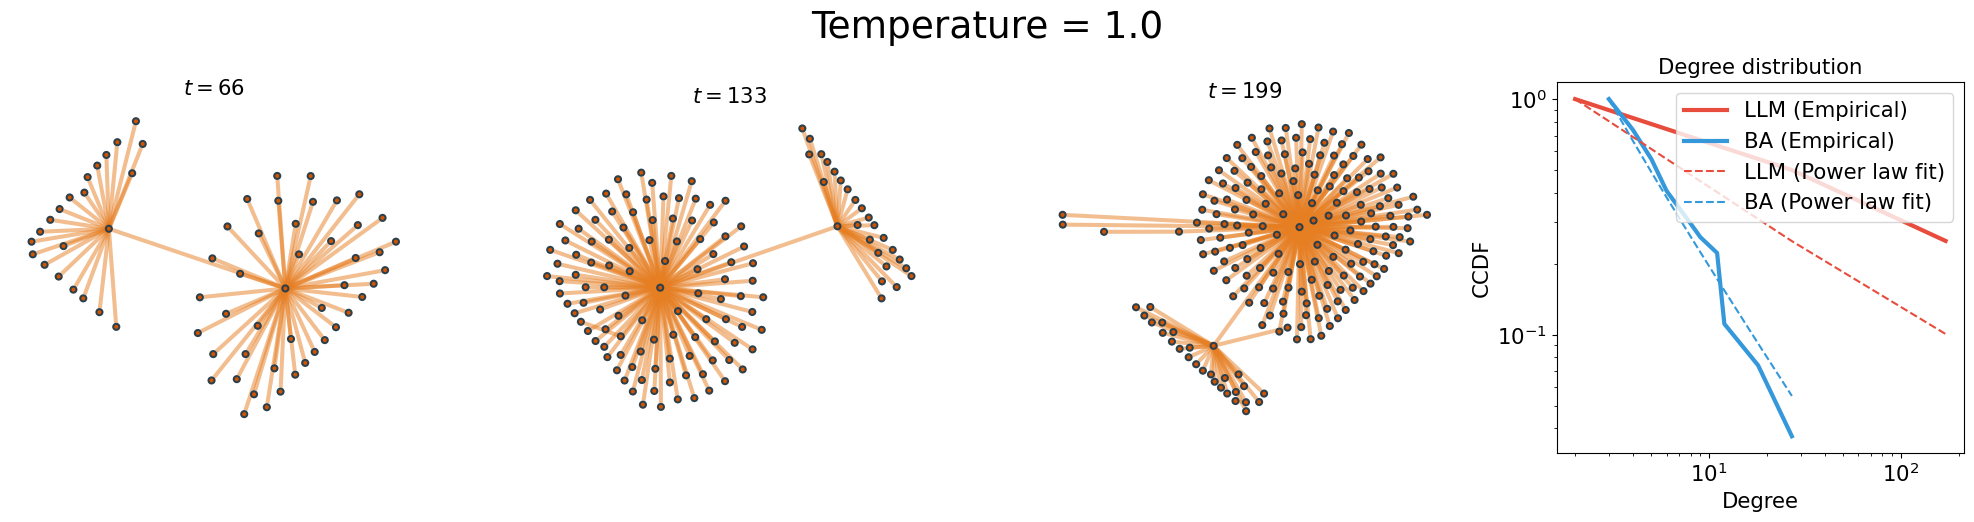

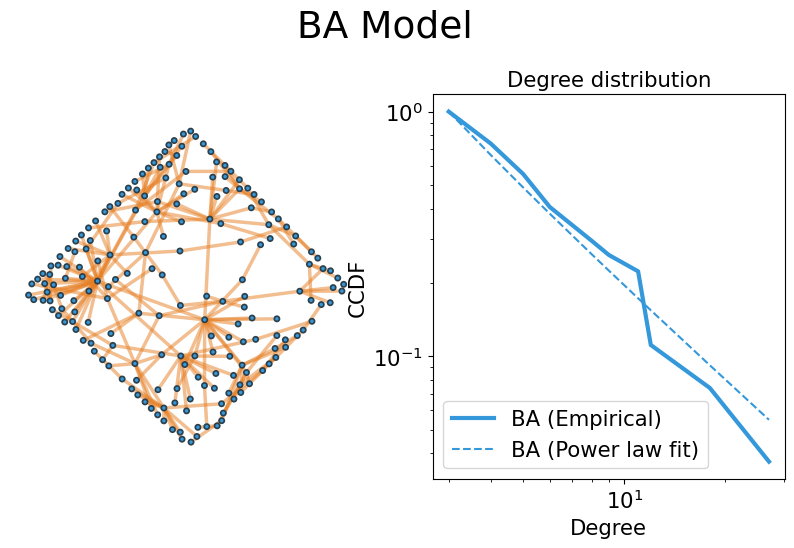

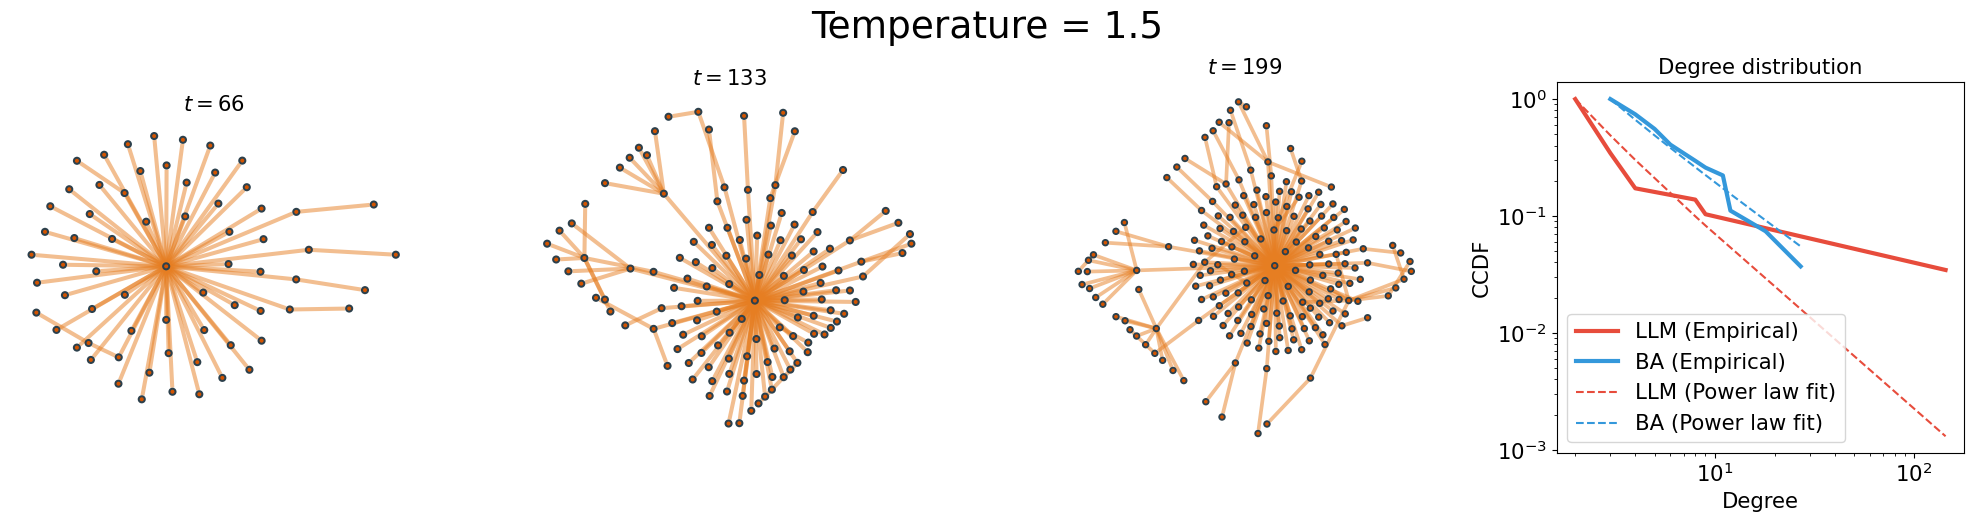

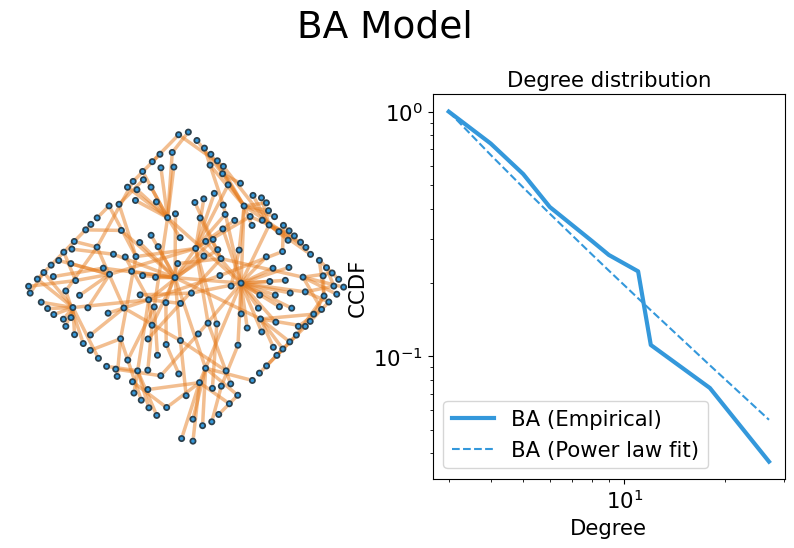

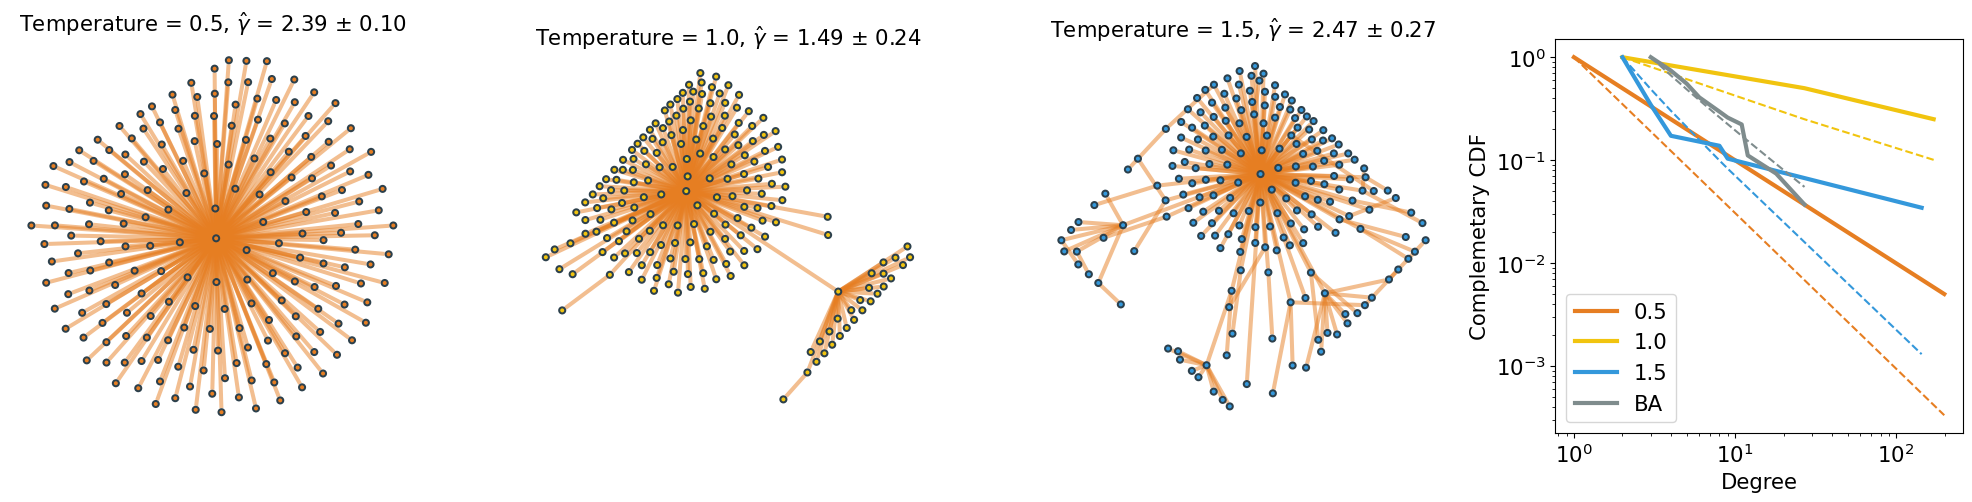

In [2]:
# run_network_formation_experiment(200, 200, 1, 1, 'outputs/principle_1_neighbors.jsonl', [0.5, 1.0, 1.5], degrees=False)
analyze_experiments('outputs/principle_1_neighbors.jsonl', dgr=False)

# run_network_formation_experiment(200, 200, 1, 1, 'outputs/principle_1.jsonl', [0.5, 1.0, 1.5], degrees=True)
analyze_experiments('outputs/principle_1.jsonl', dgr=True)


In [3]:
categories = [{'category': 'Mutual Friends', 'description': 'Reasons related to having many friends in common with the person, so the person can introduce them to their friends'}, 
              {'category': 'Well-Connected', 'description': 'Reasons related to the person being well-connected and having many friends'}]

# summarize_reasons('outputs/principle_1_neighbors_large.jsonl', degrees=False, categories=categories, n_resamples=5)
